# EVAC Examination

## Data Exploration

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math


In [140]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 7
numHiddenNodes1 = 64
numOutputNodes = 1

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) +(numHiddenNodes1 * numOutputNodes)



/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_79663/3200560116.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [141]:
data = pd.read_csv('eScooterDemand.csv')
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


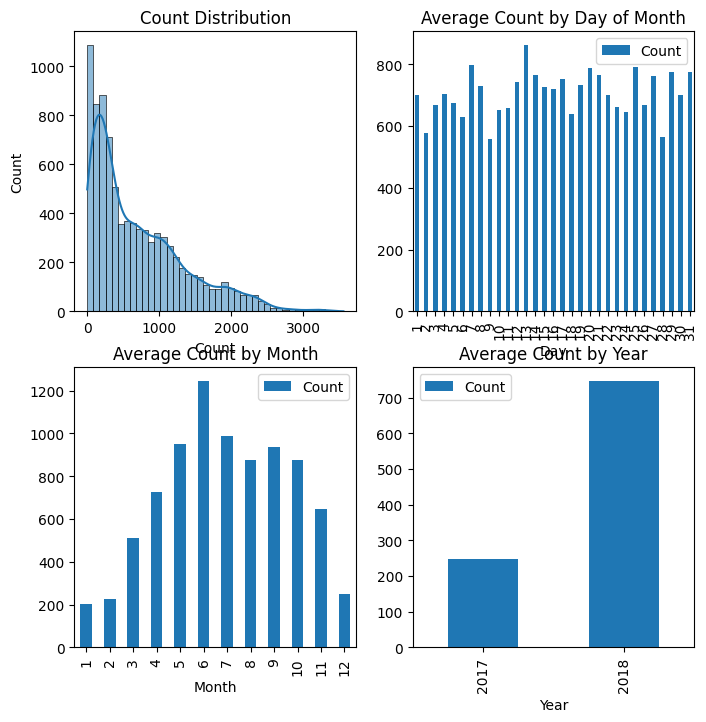

In [142]:


## plot average count over time to look for patterns that can be used to predict future demand
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['Day'] = data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')
plt.show()


In [143]:
data.query("HireAvailable=='No'").head()


,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day
3144,2018-04-11,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3145,2018-04-11,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3146,2018-04-11,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No,No,4,2018,11
3147,2018-04-11,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No,No,4,2018,11
3148,2018-04-11,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No,No,4,2018,11


## Set up representation

In [144]:
!pip install deap

In [145]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator


In [146]:
## Prepare data for training
data['Windspeed'] = data['Wind speed']
data['HireAvailable'] = data['HireAvailable'].map({'Yes': 1, 'No': 0})
data['PublicHoliday'] = data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
data['Weekend'] = data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
data['Season'] = data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [147]:
data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [148]:

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput)
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans
    
    def feedForward(self, inputs):
      inputsBias = inputs[:]
      inputsBias.insert(len(inputs),1)                 # Add bias input
      h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
      h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
      output = np.dot(self.wo, h1)                 # feed to output layer
      # output = [self.sigmoid(x) for x in output]   # Activate output layer
      return output
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

myNet = MLP(numInputNodes, numHiddenNodes1, numOutputNodes)



In [149]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [150]:
import numpy
# randomise data
data = data.sample(frac=1).reset_index(drop=True)
data = data[:500]
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


In [151]:
def eval(individual, myNet):
  myNet.setWeightsLinear(individual)
  fitness = 0
  for i in range(len(data)):
    input = [data['Temp'][i], data['Windspeed'][i], data['Visibility'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i], data['Hour'][i]]
    output = myNet.feedForward(input)
    if output[0] < 0:
      return 1000000000,
    fitness += abs(output[0] - data['Count'][i])
  return fitness,


In [152]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.5)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

baseline = toolbox.evaluate(myNet.getWeightsLinear(), myNet)
print(baseline)

(3587086.764231958,)


In [153]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [154]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
ind.fitness.values = toolbox.evaluate(ind, myNet)
print(ind.fitness.valid)
print(myNet.setWeightsLinear(ind))
print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet))

[-0.9789927116537356, -0.7325945338353026, 0.9744090572772959, -0.4236364178927172, -0.2878359650299349, -0.8233968707212214, 0.33743582442175213, 0.6930640251998708, 0.6425397642090802, 0.2897601403348866, 0.36988192219970695, 0.31482802110236374, 0.24357388033301897, -0.6698939963789636, 0.468341011346848, -0.908756202570635, -0.9857703560317754, 0.2729523892226917, 0.48612938425798635, -0.48870419247142105, 0.245651926214852, -0.8158206565085169, -0.3607329557648651, 0.32052447150930075, 0.1725835429763991, 0.4558392232458617, 0.8982561184518012, -0.6430391192930474, -0.760907626411969, -0.6835552295966496, 0.5901084385926207, 0.05970531553799252, 0.8522057602946278, -0.24782370860412084, -0.21981129572013125, 0.8117609555130503, -0.2744173637074121, -0.4782704438286163, 0.28517785305582, -0.5859384022073051, -0.08070189355836632, -0.27633926607454984, -0.8706215855492114, 0.45301289592036187, -0.6309883344033784, 0.3534649895994093, 0.6094427746819435, -0.7077202539845144, 0.309864

In [155]:
logbook = tools.Logbook()

pop = toolbox.population(n=100)

In [156]:
fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [157]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

In [158]:
print(logbook)
# import pygraphviz as pgv
# from IPython.display import Image
# best_ind = tools.selBest(pop, 1)[0]
# print(best_ind)
# print(best_ind.fitness)
# nodes, edges, labels = gp.graph(best_ind)

# tree = pgv.AGraph()
# tree.add_nodes_from(nodes)
# tree.add_edges_from(edges)
# tree.layout(prog="dot")

# for i in nodes:
#     n = tree.get_node(i)
#     n.attr["label"] = labels[i]

# treePlot = tree.draw(format="png", prog="dot")
# Image(treePlot)



avg        	gen	max  	min        	std        
4.60742e+08	0  	1e+09	251859     	4.97713e+08
2.61255e+08	1  	1e+09	222629     	4.37891e+08
2.31402e+08	2  	1e+09	222989     	4.20068e+08
2.71595e+08	3  	1e+09	249056     	4.42991e+08
3.31539e+08	4  	1e+09	271665     	4.69134e+08
2.022e+08  	5  	1e+09	296118     	3.98903e+08
2.11905e+08	6  	1e+09	232307     	4.06328e+08
2.11867e+08	7  	1e+09	300261     	4.06348e+08
3.21693e+08	8  	1e+09	216390     	4.65317e+08
2.82011e+08	9  	1e+09	220354     	4.47747e+08
3.12089e+08	10 	1e+09	217300     	4.61096e+08
2.32734e+08	11 	1e+09	366428     	4.19342e+08
2.12842e+08	12 	1e+09	242272     	4.05851e+08
2.62057e+08	13 	1e+09	214141     	4.37418e+08
3.42245e+08	14 	1e+09	405556     	4.72101e+08
1.82886e+08	15 	1e+09	219208     	3.8284e+08 
2.13299e+08	16 	1e+09	214184     	4.05614e+08
2.22871e+08	17 	1e+09	296826     	4.12726e+08
2.33097e+08	18 	1e+09	232850     	4.19146e+08
2.73471e+08	19 	1e+09	269570     	4.41858e+08
2.32988e+08	20 	1e+09	242137     	

[-1.5600936796448812, 2.7833148244338455, 2.3456092909725066, 5.309269505359493, -1.371295979000251, 0.4028105420564275, -5.3756747005059475, -1.192658503587278, 7.3691856001772145, 9.829460440798194, -0.6002135402362925, 3.2294984090726473, 1.6921640453167062, -1.2800521137822005, -0.3129378115932464, -9.091308750083375, -11.434817444507276, -1.8227605525765107, -0.45115554104816913, -8.905569410616438, -9.385328886305903, 9.156167140776498, -10.77591025849576, 9.654262657100704, 1.3843835226050676, 2.772512941080387, -3.990424083925504, -4.17943261773816, 3.074635747776383, 2.11460396232079, 3.53038213196594, -5.984091227194757, -5.4187885391243, -2.918311210457472, -7.129086188740858, -10.163659502009406, -0.7403950964870831, 3.456859795815491, -6.747332747489669, -0.4179849089138095, -5.400839383506146, 5.933894936238303, -6.036154221124928, 2.052476583446538, -8.308500384669088, 4.954222218348399, 2.0943044239730426, -1.4963169814107875, 0.3048099814813285, -4.2241067873151, -0.78

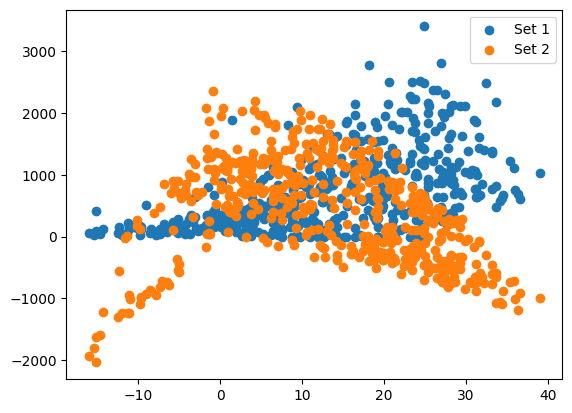

In [159]:
import matplotlib.pyplot as plt

best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(toolbox.evaluate(best_ind, myNet))
myNet.setWeightsLinear(best_ind)
print(toolbox.evaluate(best_ind, myNet))

inputs = [[data['Hour'][i],data['Temp'][i], data['Windspeed'][i], data['HireAvailable'][i], data['PublicHoliday'][i], data['Weekend'][i], data['Month'][i]] for i in range(len(data))]
# Assuming you have two sets of data:
x_values1 = data['Temp'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Temp'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([710.29107478]), array([-46.5396652]), array([631.89621085]), array([1183.11131747]), array([-440.88480626]), array([1100.86935431]), array([-166.7785732]), array([1065.9119518]), array([11.67895804]), array([710.13740138]), array([-250.11868028]), array([662.64633483]), array([836.54536058]), array([-324.88486837]), array([669.30473456]), array([-220.78810676]), array([-298.78557881]), array([-51.07130842]), array([-193.27583017]), array([699.6002533]), array([790.94117705]), array([87.1032992]), array([1244.0025078]), array([-715.68569489]), array([2031.11260133]), array([595.75878634]), array([871.34917267]), array([808.39185175]), array([-766.25578995]), array([-360.56936888]), array([760.82985241]), array([1912.69909494]), array([-98.39494468]), array([2056.16431019]), array([51.7014534]), array([-42.42376744]), array([-659.00925653]), array([807.81583826]), array([-297.96691758]), array([-467.19521956]), array([1567.79712393]), array([1541.92899989]), array([350.59253304])

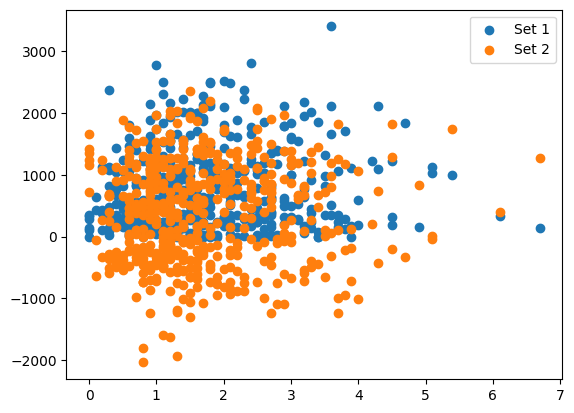

In [160]:
# Assuming you have two sets of data:
x_values1 = data['Windspeed'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Windspeed'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[array([710.29107478]), array([-46.5396652]), array([631.89621085]), array([1183.11131747]), array([-440.88480626]), array([1100.86935431]), array([-166.7785732]), array([1065.9119518]), array([11.67895804]), array([710.13740138]), array([-250.11868028]), array([662.64633483]), array([836.54536058]), array([-324.88486837]), array([669.30473456]), array([-220.78810676]), array([-298.78557881]), array([-51.07130842]), array([-193.27583017]), array([699.6002533]), array([790.94117705]), array([87.1032992]), array([1244.0025078]), array([-715.68569489]), array([2031.11260133]), array([595.75878634]), array([871.34917267]), array([808.39185175]), array([-766.25578995]), array([-360.56936888]), array([760.82985241]), array([1912.69909494]), array([-98.39494468]), array([2056.16431019]), array([51.7014534]), array([-42.42376744]), array([-659.00925653]), array([807.81583826]), array([-297.96691758]), array([-467.19521956]), array([1567.79712393]), array([1541.92899989]), array([350.59253304])

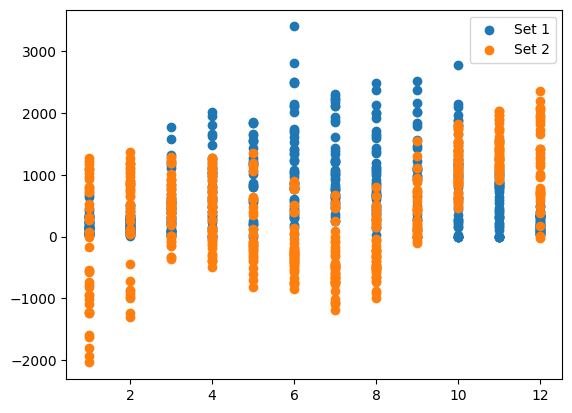

In [161]:
# Assuming you have two sets of data:
x_values1 = data['Month'].to_list()
y_values1 = data['Count'].to_list()

x_values2 = data['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()